In [1]:
import gymnasium as gym
import numpy as np

In [2]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env.reset()
ss = env.observation_space.sample()
print(ss)



[0.33370125 0.04601089]


In [6]:
print(env.action_space.sample())
env.action_space

2


Discrete(3)

IndexError: index 2 is out of bounds for axis 1 with size 2

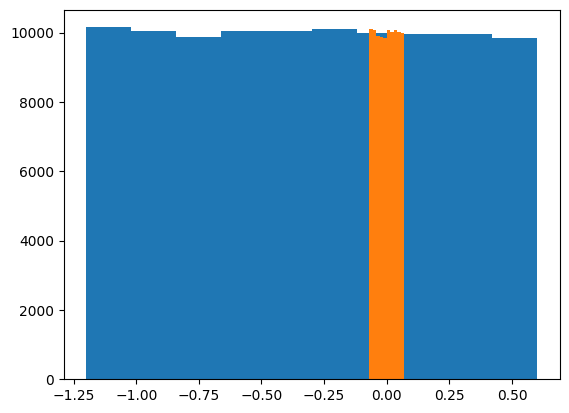

In [5]:
import matplotlib.pyplot as plt

total_obs = []
for i in range(100000):
    sample = env.observation_space.sample()
    total_obs.append(sample)

total_obs = np.array(total_obs)
plt.hist(total_obs[:,0]) # car position
plt.hist(total_obs[:,1]) # car velocity

print(np.min(total_obs[:,0]))
print(np.min(total_obs[:,1]))


[0.49710184 0.00110421]
22
[-0.8253537   0.03981377]
8
[-0.31788868 -0.00993624]
12
[-0.13757364  0.04953869]
14
[-0.26207578 -0.0679388 ]
10
[-0.2541658  -0.00743545]
12
[-0.9536268   0.00102312]
2
[-0.95535   -0.0049012]
2
[-0.8479011  -0.05463114]
0
[-1.0071042   0.06130666]
4
[-0.21904968 -0.05517612]
10
[-0.15490678  0.03581788]
13
[ 0.10442865 -0.01432706]
16
[-1.0704054  -0.03698575]
1
[ 0.5142281  -0.05261743]
20
[-0.4429695  -0.04482754]
10
[-0.00278717 -0.00068699]
17
[-0.9954369   0.01527638]
3
[-1.1545242  -0.01894347]
1
[0.25206047 0.01433509]
23
[0.4869047  0.02615946]
23
[-0.77504575 -0.0505818 ]
5
[0.56667864 0.03190326]
23
[-0.90684545 -0.03532927]
1
[-0.800016   -0.02235405]
6
[-0.24844594 -0.05716311]
10
[0.42417693 0.02580045]
23
[-1.1613091   0.05064487]
4
[-0.757472   0.0186538]
8
[-0.44260442 -0.06212172]
10
[-0.29979125  0.04755417]
14
[0.51127326 0.01809815]
23
[0.55276614 0.0616451 ]
24
[-0.7180143   0.01364228]
7
[-0.02368841 -0.03046732]
16
[-0.8720397   0.0

(array([386., 444., 365., 417., 397., 394., 401., 389., 415., 382., 425.,
        393., 422., 390., 393., 417., 400., 368., 391., 411., 429., 394.,
        357., 402., 418.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <BarContainer object of 25 artists>)

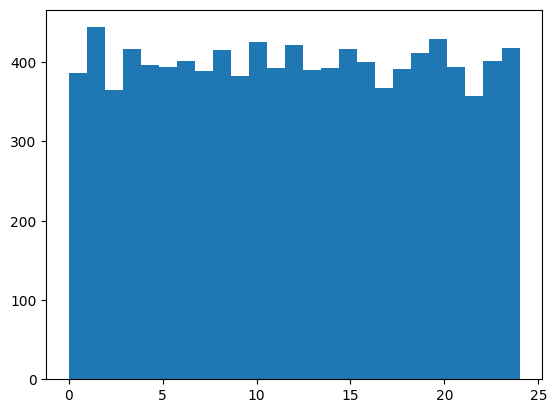

In [50]:
# hyperparameters
num_episodes = 50000
num_actions = 3 # change depending on num observable actions
state_vars = 2 # change depending on num observable states
num_states = 5**state_vars
Q = np.zeros((num_states, num_actions))
gamma = 0.999
alpha = 0.25
epsilon = 1.0
epsilon_min = 0
decay_factor = 0.999 # use exponential decay

num_bins = 5
total_reward = 0

def discretize(s):
    def clamp(low, high, val):
        return min(high, max(low, val))

    # Define ranges
    pos_range, vel_range = (-1.2,0.6), 0.07

    # Clip inputs
    position = clamp(pos_range[0], pos_range[1], s[0])
    velocity = clamp(-vel_range, vel_range, s[1])

    # Calculate bin index (0 to num_bins) for each dimension
    # Using num_bins (5) in scaling
    pos_bin_raw = int((position - pos_range[0]) / (pos_range[1]-pos_range[0]) * num_bins)
    vel_bin_raw = int((velocity + vel_range) / (2 * vel_range) * num_bins)

    # --- Add Clamping for Edge Cases ---
    # Ensure indices are between 0 and num_bins-1 (e.g., 0 and 4)
    pos_bin = min(pos_bin_raw, num_bins - 1)
    vel_bin = min(vel_bin_raw, num_bins - 1)
    # ----------------------------------

    # Combine using base-5 multipliers (5, 1)
    index = pos_bin * (num_bins**1) + vel_bin * (num_bins**0)

    # Final safety clamp (shouldn't be needed if above is correct, but doesn't hurt)
    index = max(0, min(index, num_states - 1)) # num_states is 625 here

    return index

discretized = []
for i in range(10000):
    s = env.observation_space.sample()
    print(s)
    ds = discretize(s)
    print(ds)
    discretized.append(ds)

nd = np.array(discretized)
plt.hist(nd, bins=25)

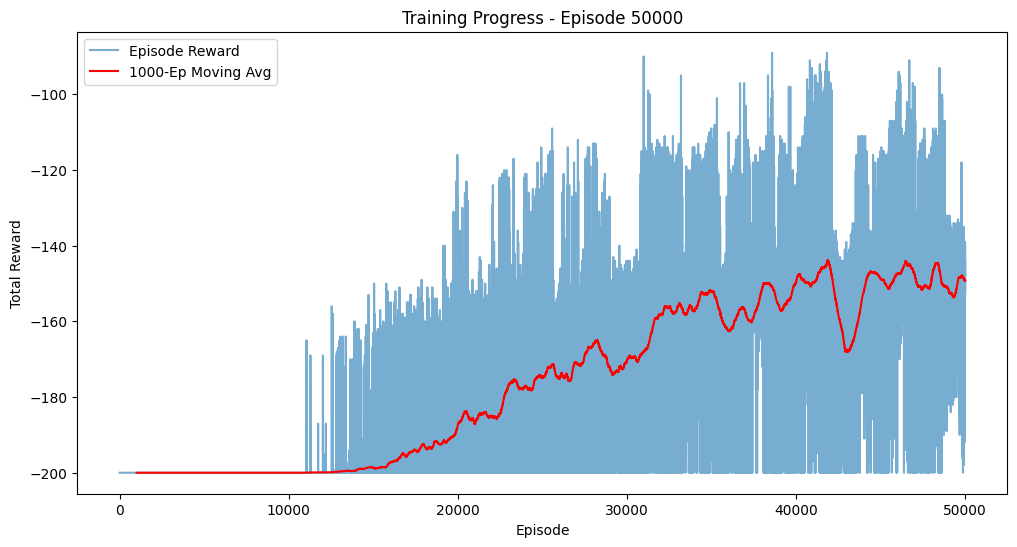

100%|██████████| 50000/50000 [02:12<00:00, 377.00it/s]


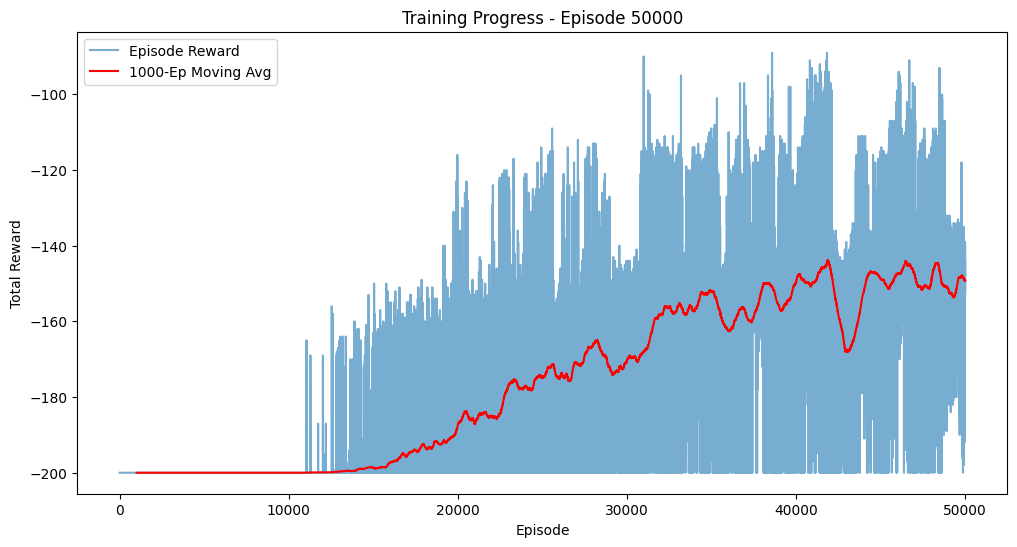

In [80]:
from tqdm import tqdm
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
from IPython.display import display, clear_output

# hyperparameters
num_episodes = 50000
num_actions = 3 # change depending on num observable actions
state_vars = 2 # change depending on num observable states
num_bins = 20
num_states = num_bins**state_vars
Q = np.zeros((num_states, num_actions))
gamma = 0.999

alpha = 0.1
alpha_min = 0.001
alpha_decay_factor = 0.99995

epsilon = 1.0
epsilon_min = 0.01
decay_factor = 0.99995 # use exponential decay

def clamp(low, high, val):
        return min(high, max(low, val))

def discretize(s):
    # Define ranges
    pos_range, vel_range = (-1.2,0.6), 0.07

    # Clip inputs
    position = clamp(pos_range[0], pos_range[1], s[0])
    velocity = clamp(-vel_range, vel_range, s[1])

    # Calculate bin index (0 to num_bins) for each dimension
    pos_bin_raw = int((position - pos_range[0]) / (pos_range[1]-pos_range[0]) * num_bins)
    vel_bin_raw = int((velocity + vel_range) / (2 * vel_range) * num_bins)

    # --- Add Clamping for Edge Cases ---
    # Ensure indices are between 0 and num_bins-1 (e.g., 0 and 4)
    pos_bin = min(pos_bin_raw, num_bins - 1)
    vel_bin = min(vel_bin_raw, num_bins - 1)

    # Combine using base-num_bin multipliers
    index = pos_bin * (num_bins**1) + vel_bin * (num_bins**0)

    # Final safety clamp (shouldn't be needed if above is correct, but doesn't hurt)
    index = max(0, min(index, num_states - 1))

    return index

def get_next_step(Q, s, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[s])

def update_q(Q, s, a, reward, gamma, alpha, s_p, done):
    if done:
        target = reward # reward is negative 1 for each timestep you aren't at the top
    else:
        target = reward + gamma * np.max(Q[s_p])
    td_error = target - Q[s,a] 
    Q[s,a] = Q[s,a] + alpha * td_error

training_period = num_episodes / 10
env = gym.make('MountainCar-v0', render_mode="rgb_array")
env = RecordVideo(env, video_folder="mountaincar-agent", name_prefix="training",
                  episode_trigger=lambda x: x % training_period == 0)
env = RecordEpisodeStatistics(env, buffer_length=num_episodes)

# --- Plotting Setup ---
moving_avg_window = 1000 # Adjust as needed
update_plot_every = 1000 # Adjust as needed
fig, ax = plt.subplots(figsize=(12, 6))

# --- Data Storage for Plotting ---
all_episode_rewards = [] # Use your own list to store ALL rewards

for episode in tqdm(range(num_episodes)):
    obs, info  = env.reset()
    done = False

    while not done:
        s = discretize(obs)
        step = get_next_step(Q, s, epsilon)

        # retrieve new observation from environment
        next_obs, reward, terminated, truncated, info = env.step(step)
        if 'episode' in info:
            episode_return = info['episode']['r']
            all_episode_rewards.append(episode_return)

        if terminated or truncated:
            done = True
            
        # update Q function estimate
        s_p = discretize(next_obs)
        update_q(Q, s, step, reward, gamma, alpha, s_p, done)
            
        obs = next_obs

    epsilon = max(epsilon_min, epsilon * decay_factor)
    # alpha -= alpha_decay_factor
    alpha = max(alpha_min, alpha * alpha_decay_factor)

    if episode % (num_episodes / 10) == 0:
        print (f"episode-{episode} max reward to this point {np.max(env.return_queue)}")

    # --- Update Plot Periodically (using your FULL list) ---
    if (episode + 1) % update_plot_every == 0 and len(all_episode_rewards) > 0:
        clear_output(wait=True) # Clear previous output
        ax.cla() # Clear axes for fresh plot

        # Replot data
        ax.plot(all_episode_rewards, label='Episode Reward', alpha=0.6)
        if len(all_episode_rewards) >= moving_avg_window:
            moving_avg = np.convolve(all_episode_rewards, np.ones(moving_avg_window)/moving_avg_window, mode='valid')
            ax.plot(np.arange(moving_avg_window - 1, len(all_episode_rewards)), moving_avg, label=f'{moving_avg_window}-Ep Moving Avg', color='red')

        # Reset labels and title
        ax.set_xlabel("Episode")
        ax.set_ylabel("Total Reward")
        ax.set_title(f"Training Progress - Episode {episode + 1}")
        ax.legend()

        # Display the updated figure in the cell output
        display(fig)

env.close()

In [66]:
Q

array([[-112.92677926, -103.43639231, -111.70897103],
       [-108.87741471, -110.47134221, -111.01553131],
       [-110.22767076, -109.75790669, -101.5370462 ],
       [ -88.92535391,  -88.70840748,  -77.65839086],
       [ -73.96591203,  -78.65533654,  -53.91416644],
       [-112.98235277, -119.55940724, -120.85211379],
       [-126.40570171, -140.92484316, -140.43379949],
       [-157.44438859, -156.62908973, -151.47736649],
       [-115.32055452, -115.08074481, -107.63687133],
       [ -70.63535673,  -70.36481112,  -58.68714473],
       [-117.08942908, -120.81495004, -120.56772392],
       [-133.54927786, -136.12466874, -136.04253013],
       [-148.69550473, -154.68421966, -155.35571153],
       [-130.09696651, -130.68986992, -119.73789903],
       [ -73.46433896,  -71.74093626,  -56.79977307],
       [-117.88559898, -118.10794636, -118.11685439],
       [-131.18731842, -131.28580762, -131.1823669 ],
       [-127.60100426, -134.71348749, -135.75093846],
       [-116.40048211, -119.

Episode time taken: deque([0.025836, 0.000461, 0.000348, 0.000147, 0.000137, 0.000234, 0.000244, 0.000317, 0.00028, 0.000156, 0.000303, 0.000119, 0.000548, 0.000346, 0.000132, 0.000371, 0.000222, 0.00022, 0.000464, 0.000193, 0.000295, 0.000174, 0.000478, 0.000191, 0.000375, 0.000259, 0.000129, 0.000134, 0.000324, 0.00042, 0.000385, 0.000166, 0.000215, 0.000374, 0.000353, 0.000142, 0.000373, 0.000274, 0.000275, 0.000105, 0.000275, 0.000179, 0.000238, 0.000142, 0.000278, 0.000158, 0.000377, 0.000614, 0.000539, 0.000179, 0.000254, 0.000482, 0.000196, 0.00029, 0.000262, 0.000651, 0.000164, 0.000215, 0.001028, 0.000211, 0.000272, 0.000187, 0.000174, 0.00056, 0.00021, 0.00021, 0.000153, 0.000719, 0.000221, 0.000345, 0.000125, 0.000155, 0.000162, 0.00059, 0.000187, 0.000151, 0.00044, 0.000162, 0.000174, 0.000351, 0.000114, 0.000223, 0.000383, 0.000271, 0.000459, 0.00021, 0.000477, 0.000198, 0.000562, 0.000568, 0.00017, 0.000126, 0.000213, 0.000526, 0.000138, 0.000238, 0.000296, 0.000417, 0.00

50000

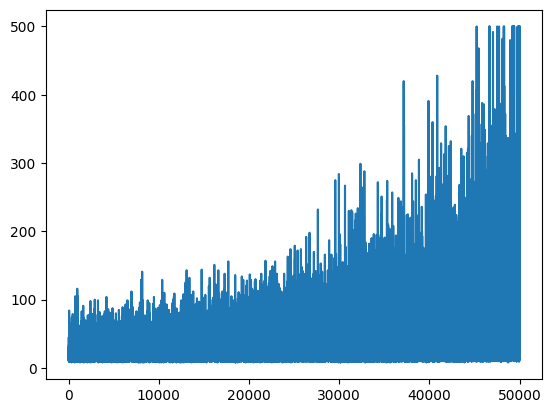

In [28]:
np.max(Q)

# plt.plot(total_rewards)

print(f'Episode time taken: {env.time_queue}')
print(f'Episode total rewards: {env.return_queue}')
print(f'Episode lengths: {env.length_queue}')
plt.plot(env.return_queue)

len(env.return_queue)